In [3]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Utility to measure time
def measure_time(func):
    start_time = time.time()
    result = func()
    elapsed_time = time.time() - start_time
    return result, elapsed_time

# Utility to check for convergence
def has_converged(train_acc, val_acc, threshold=0.01):
    return abs(train_acc - val_acc) <= threshold


In [4]:
# CIFAR-10 dataset
def get_cifar10_loaders(batch_size=32):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# MNIST dataset
def get_mnist_loaders(batch_size=32):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


In [5]:
# Define the CNN model with convolutional layers for CIFAR-10
class SimpleCNN_CIFAR(nn.Module):
    def __init__(self):
        super(SimpleCNN_CIFAR, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.max_pool(self.relu(self.conv1(x)))
        x = self.max_pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)  # Flatten the feature map for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_until_convergence(model, train_loader, test_loader, optimizer, criterion, device, patience=5):
    model.to(device)
    train_acc_history, val_acc_history, train_loss_history = [], [], []
    no_improvement_count = 0

    for epoch in range(10):  # We allow up to 100 epochs, but we'll stop early
        model.train()
        correct_train, total_train = 0, 0
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_acc_history.append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Check for convergence
        #if has_converged(train_acc, val_acc):
        #    print(f'Convergence reached at epoch {epoch+1}!')
        #    break

        # Early stopping if there's no improvement
        if len(val_acc_history) > 1 and val_acc_history[-1] <= val_acc_history[-2]:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch+1} due to no improvement.')
                break
        else:
            no_improvement_count = 0

    return train_acc_history, val_acc_history, train_loss_history, model


In [14]:
def execute_training(device_name="cpu"):
    device = torch.device(device_name)

    # Model, optimizer, and loss function
    model = SimpleCNN_CIFAR()  # Or SimpleCNN if using the model defined earlier for MNIST/CIFAR10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Get data loaders
    train_loader, test_loader = get_cifar10_loaders()

    # Train the model
    def train_func():
        return train_until_convergence(model, train_loader, test_loader, optimizer, criterion, device)

    result, elapsed_time = measure_time(train_func)
    train_acc_history, val_acc_history, train_loss_history, model = result

    print(f'Training on {device_name.upper()} took {elapsed_time:.2f} seconds.')
    return train_acc_history, val_acc_history, elapsed_time, model


In [15]:
# Run on GPU if available
if torch.cuda.is_available():
    gpu_results = execute_training("cuda")
    
# Run on CPU
cpu_results = execute_training("cpu")

# Save results and plot


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.2916, Train Acc: 53.68%, Val Acc: 62.71%
Epoch 2: Train Loss: 0.9164, Train Acc: 67.61%, Val Acc: 69.18%
Epoch 3: Train Loss: 0.7586, Train Acc: 73.42%, Val Acc: 70.28%
Epoch 4: Train Loss: 0.6356, Train Acc: 77.65%, Val Acc: 71.86%
Epoch 5: Train Loss: 0.5308, Train Acc: 81.28%, Val Acc: 71.03%
Epoch 6: Train Loss: 0.4313, Train Acc: 84.74%, Val Acc: 71.44%
Epoch 7: Train Loss: 0.3447, Train Acc: 87.82%, Val Acc: 71.12%
Epoch 8: Train Loss: 0.2730, Train Acc: 90.28%, Val Acc: 72.19%
Epoch 9: Train Loss: 0.2106, Train Acc: 92.57%, Val Acc: 70.65%
Epoch 10: Train Loss: 0.1697, Train Acc: 93.91%, Val Acc: 70.50%
Training on CUDA took 161.17 seconds.
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train Loss: 1.2929, Train Acc: 53.83%, Val Acc: 64.22%
Epoch 2: Train Loss: 0.9170, Train Acc: 67.70%, Val Acc: 67.72%
Epoch 3: Train Loss: 0.7651, Train Acc: 7

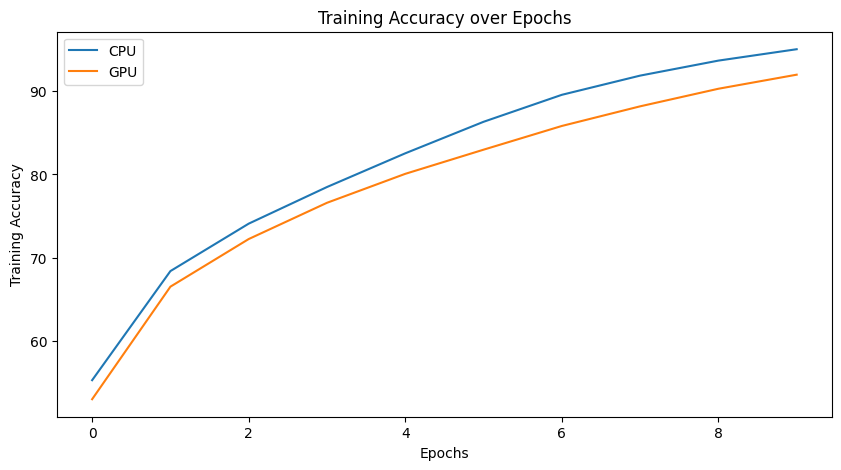

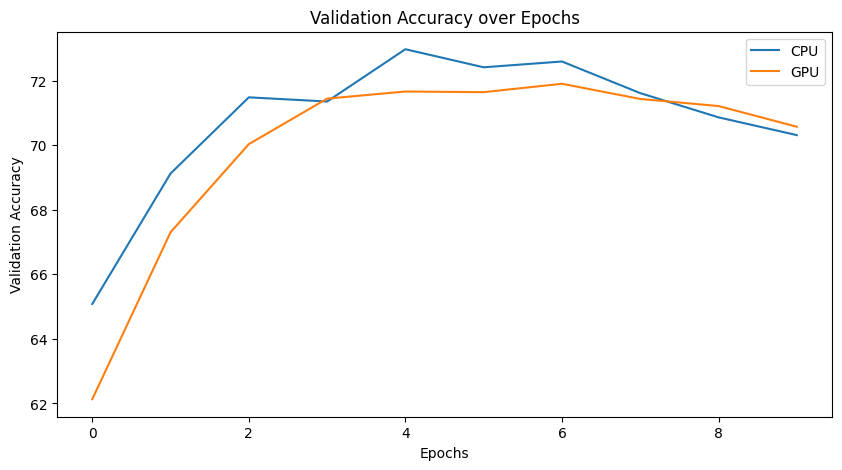

In [12]:
import matplotlib.pyplot as plt

# Example function to plot training and validation accuracy
def plot_results(cpu_history, gpu_history, metric_name):
    plt.figure(figsize=(10, 5))
    
    plt.plot(cpu_history, label='CPU')
    if gpu_history:
        plt.plot(gpu_history, label='GPU')
    
    plt.title(f'{metric_name} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Plot training accuracy and validation accuracy
plot_results(cpu_results[0], gpu_results[0], 'Training Accuracy')
plot_results(cpu_results[1], gpu_results[1], 'Validation Accuracy')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].


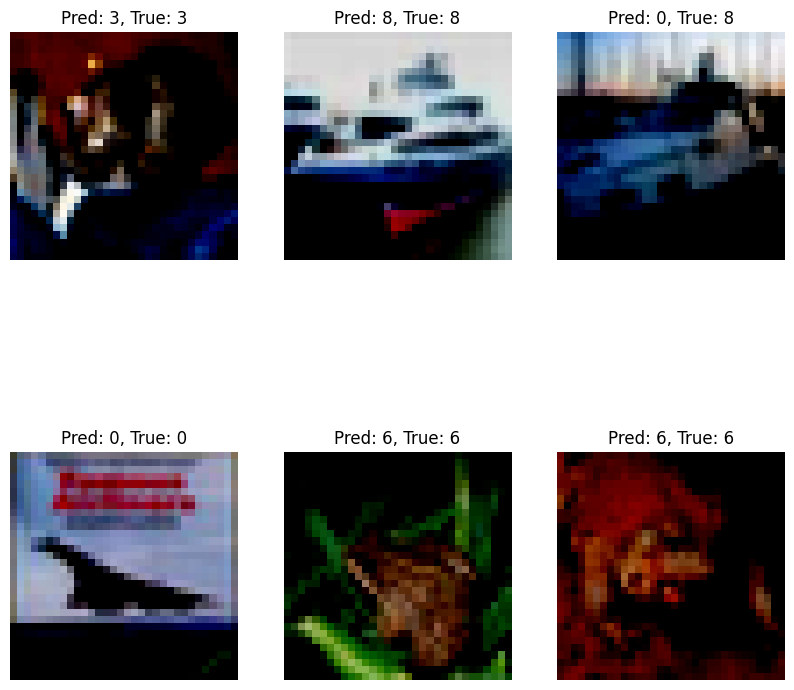

In [16]:
def show_test_images_with_predictions(model, test_loader):
    device = next(model.parameters()).device
    model.eval()
    images, labels = next(iter(test_loader))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(6):  # Show 6 images
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from tensor to image format
        plt.title(f'Pred: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

train_loader, test_loader = get_cifar10_loaders()

show_test_images_with_predictions(cpu_results[-1], test_loader)


In [2]:
model = cpu_results[-1]
torch.save(model.state_dict(), 'models/simple_cnn_cifar.pth')


In [20]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_set_mnist, batch_size=32, shuffle=True)
test_loader_mnist = DataLoader(test_set_mnist, batch_size=32, shuffle=False)


In [21]:
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.01, 
    target_modules=["conv1", "conv2", "fc1", "fc2"],  # Apply LoRA to both conv and linear layers
    bias="none"
)

# Apply LoRA to the loaded CIFAR-10 model
peft_model = get_peft_model(model, lora_config)


In [ ]:
# Set up the optimizer and loss function for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, peft_model.parameters()), lr=0.001)

# Fine-tuning loop on MNIST
train_model(peft_model, train_loader_mnist, epochs=5)

# Save the fine-tuned model
torch.save(peft_model.state_dict(), 'lora_finetuned_mnist.pth')


In [ ]:
import matplotlib.pyplot as plt

# Perform inference on test data
peft_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = peft_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')

# Display a few test images with predictions
def show_predictions(model, loader, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    outputs = model(images.to(device))
    _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Predicted: {preds[i].item()}, True: {labels[i].item()}')
        plt.axis('off')
    plt.show()

# Show predictions
show_predictions(peft_model, test_loader_mnist)


In [ ]:
torch.save(model.state_dict(), 'model_name.pth')


In [ ]:
import matplotlib.pyplot as plt

# Example function to plot training loss
def plot_loss(losses, label):
    plt.plot(losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# Assuming you have loss lists for CPU and GPU runs
plot_loss(cpu_losses, 'CPU Training')
plot_loss(gpu_losses, 'GPU Training')
plt.show()
